In [1]:
#%pip install torch transformers pandas matplotlib sklearn seaborn tqbm

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

c:\Users\krigi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Настройки
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL = "DeepPavlov/rubert-base-cased"
BATCH_SIZE = 32
PATIENCE = 4
EPOCHS = 15
MAX_LEN = 256
NUM_CLASSES = 3 

In [4]:
print(DEVICE) #проверка

cuda


In [5]:
# загрузка датасета рандомно
df = pd.read_pickle("tokenized_dataset.pkl")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df.head()

,text,label,src,clean_text,input_ids,attention_mask
0,Наблюдал веселую картину: сотрудник сто чуть н...,2,geo,наблюдал веселую картину сотрудник сто чуть не...,"[101, 51120, 53086, 1790, 23459, 18040, 8590, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"После просмотра данного анимэ, странное чувств...",0,anime,"после просмотра данного анимэ, странное чувств...","[101, 3468, 37854, 17719, 22303, 900, 128, 819...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,платье велико !\n\n\n\n\n\nВиталий.\n\ne-mail:...,0,ru-reviews-classification,платье велико ! виталий. e-mail zvp2012 yandex.ru,"[101, 41361, 63990, 106, 22556, 20059, 132, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"качество отвратительное, колючая. нет ни перед...",0,rureviews,"качество отвратительное, колючая. нет ни перед...","[101, 24991, 63162, 12127, 128, 46553, 1637, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Достоинства: Густая и очень вкусная Моя любима...,1,perekrestok,достоинства густая и очень вкусная моя любимая...,"[101, 30731, 110204, 851, 7805, 28884, 2630, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."


In [7]:
# деление на train test val
train_val_df, test_df = train_test_split(
    df,
    test_size=0.05,
    stratify=df["label"],
    random_state=42
)
print(f"Total: {len(df)} examples")
print(f"Train+Val: {len(train_val_df)} ({len(train_val_df)/len(df):.1%})")
print(f" Test:     {len(test_df)} ({len(test_df)/len(df):.1%})\n")

Total: 290458 examples
Train+Val: 275935 (95.0%)
 Test:     14523 (5.0%)



In [8]:
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.053,
    stratify=train_val_df["label"],
    random_state=42
)
print(f"Train: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"  Val: {len(val_df)} ({len(val_df)/len(df):.1%})")

Train: 261310 (90.0%)
  Val: 14625 (5.0%)


In [9]:
def to_tensor_df(dataframe):
    dataframe["input_ids"] = dataframe["input_ids"].apply(lambda x: torch.tensor(x, dtype=torch.long))
    dataframe["attention_mask"] = dataframe["attention_mask"].apply(lambda x: torch.tensor(x, dtype=torch.long))
    dataframe["label"] = dataframe["label"].astype(int)
    return dataframe

In [10]:
train_df = to_tensor_df(train_df)
val_df = to_tensor_df(val_df)
test_df  = to_tensor_df(test_df)

In [11]:
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "input_ids": row["input_ids"],
            "attention_mask": row["attention_mask"],
            "label": torch.tensor(row["label"], dtype=torch.long)
        }


In [12]:
train_loader = DataLoader(SentimentDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SentimentDataset(val_df), batch_size=BATCH_SIZE)
test_loader = DataLoader(SentimentDataset(test_df), batch_size=BATCH_SIZE)

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.3):
        super(SelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out   = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):  # x: [batch, seq_len, embed_dim]
        b, seq_len, _ = x.size()
        Q = self.query(x).view(b, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        K = self.key(x).view(b, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        V = self.value(x).view(b, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        scores = torch.matmul(Q, K.transpose(-2,-1)) / (self.head_dim ** 0.5)
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)
        context = torch.matmul(weights, V)

        context = context.transpose(1,2).contiguous().view(b, seq_len, self.embed_dim)
        return self.out(context)


In [14]:
#мейн модел
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, bert_model_name, num_classes, freeze_bert=True, num_heads=4, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.filter_sizes = [3, 4, 5, 6, 8]
        self.num_filters = 128
        self.hidden_lstm = 128
        self.num_lstm_layers = 2

        self.convs = nn.ModuleList([
            nn.Conv1d(768, self.num_filters, fs, padding=fs // 2)
            for fs in self.filter_sizes
        ])

        self.lstms = nn.ModuleList([
            nn.LSTM(self.num_filters, self.hidden_lstm, self.num_lstm_layers,
                    batch_first=True, bidirectional=True, dropout=dropout if self.num_lstm_layers>1 else 0.0)
            for _ in self.filter_sizes
        ])

        self.self_attn = SelfAttention(embed_dim=self.hidden_lstm*2, num_heads=num_heads, dropout=dropout)

        total_attn_size = len(self.filter_sizes) * self.hidden_lstm * 2
        self.fc1 = nn.Linear( total_attn_size, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)
        
        feats = []
        for conv, lstm in zip(self.convs, self.lstms):
            c = F.relu(conv(x)).permute(0, 2, 1)  # [b, seq, num_filters]
            c = self.dropout(c)

            h, _ = lstm(c)  # [b, seq, hidden*2]
            h = self.dropout(h)

            a = self.self_attn(h)  # [b, seq, hidden*2]
            a = self.dropout(a)
            
            # Global max pooling over sequence
            pooled, _ = torch.max(a, dim=1)  # [b, hidden*2]
            feats.append(pooled)

        cat = torch.cat(feats, dim=1)  # [b, total_feat]

        out = F.relu(self.fc1(cat))
        out = self.dropout(out)
        
        return self.fc2(out)

In [15]:
#обучение
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torch import autocast, GradScaler

model = CNN_BiLSTM_Attention(BERT_MODEL, NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau( optimizer, mode="max", factor=0.5, patience=2)
scaler = GradScaler() 

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def train_epoch(model, loader):
    model.train()
    losses, preds, labels = [], [], []

    for batch in tqdm(loader, desc="Train"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        targets = batch["label"].to(DEVICE)

        with autocast("cuda"): 
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()     
        scaler.step(optimizer)            
        scaler.update()                   

        losses.append(loss.item())
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
    
    train_loss = sum(losses) / len(losses)
    train_accuracy = accuracy_score(labels, preds)
    train_f1 = f1_score(labels, preds, average="macro")

    return train_loss, train_accuracy, train_f1

In [17]:
def eval_epoch(model, loader):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            targets = batch["label"].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    val_loss = sum(losses) / len(losses)
    val_accuracy = accuracy_score(labels, preds)
    val_f1 = f1_score(labels, preds, average="macro")


    return val_loss, val_accuracy, val_f1


In [18]:
best_val_f1 = 0
epochs_no_improve = 0

import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader)
    print(f"[Train] Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f}")
    val_loss, val_acc, val_f1 = eval_epoch(model, val_loader)
    print(f"[Val]   Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")
    
    prev_lrs = [g["lr"] for g in optimizer.param_groups]
    scheduler.step(val_f1)
    new_lrs = [g["lr"] for g in optimizer.param_groups]
    if new_lrs != prev_lrs:
        print(f"⤵️  LR reduced: {new_lrs}")
    else:
        print(f"💡 Current lrs: {new_lrs}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "cnn_bilstm_attention1.pt")
        print("✓ Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("✋ Early stopping triggered.")
            break


Epoch 1/15


Train: 100%|██████████| 8166/8166 [15:38<00:00,  8.70it/s]


[Train] Loss: 0.7663 Acc: 0.6429 F1: 0.6422


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.7124 Acc: 0.6776 F1: 0.6812
💡 Current lrs: [4e-05]
✓ Saved new best model.

Epoch 2/15


Train: 100%|██████████| 8166/8166 [15:36<00:00,  8.72it/s]


[Train] Loss: 0.7005 Acc: 0.6778 F1: 0.6776


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6737 Acc: 0.6915 F1: 0.6956
💡 Current lrs: [4e-05]
✓ Saved new best model.

Epoch 3/15


Train: 100%|██████████| 8166/8166 [15:35<00:00,  8.73it/s]


[Train] Loss: 0.6707 Acc: 0.6925 F1: 0.6924


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6620 Acc: 0.6966 F1: 0.6993
💡 Current lrs: [4e-05]
✓ Saved new best model.

Epoch 4/15


Train: 100%|██████████| 8166/8166 [15:40<00:00,  8.68it/s]


[Train] Loss: 0.6510 Acc: 0.7024 F1: 0.7025


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6560 Acc: 0.7006 F1: 0.7063
💡 Current lrs: [4e-05]
✓ Saved new best model.

Epoch 5/15


Train: 100%|██████████| 8166/8166 [15:38<00:00,  8.70it/s]


[Train] Loss: 0.6369 Acc: 0.7108 F1: 0.7108


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6404 Acc: 0.7093 F1: 0.7143
💡 Current lrs: [4e-05]
✓ Saved new best model.

Epoch 6/15


Train: 100%|██████████| 8166/8166 [15:36<00:00,  8.72it/s]


[Train] Loss: 0.6227 Acc: 0.7181 F1: 0.7181


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6420 Acc: 0.7043 F1: 0.7075
💡 Current lrs: [4e-05]

Epoch 7/15


Train: 100%|██████████| 8166/8166 [15:23<00:00,  8.84it/s]


[Train] Loss: 0.6112 Acc: 0.7233 F1: 0.7233


Eval: 100%|██████████| 458/458 [01:31<00:00,  5.01it/s]


[Val]   Loss: 0.6339 Acc: 0.7119 F1: 0.7141
💡 Current lrs: [4e-05]

Epoch 8/15


Train: 100%|██████████| 8166/8166 [15:43<00:00,  8.66it/s]


[Train] Loss: 0.5997 Acc: 0.7289 F1: 0.7290


Eval: 100%|██████████| 458/458 [01:30<00:00,  5.04it/s]


[Val]   Loss: 0.6197 Acc: 0.7140 F1: 0.7128
⤵️  LR reduced: [2e-05]

Epoch 9/15


Train: 100%|██████████| 8166/8166 [15:30<00:00,  8.78it/s]


[Train] Loss: 0.5782 Acc: 0.7398 F1: 0.7398


Eval: 100%|██████████| 458/458 [01:29<00:00,  5.12it/s]


[Val]   Loss: 0.6214 Acc: 0.7186 F1: 0.7218
💡 Current lrs: [2e-05]
✓ Saved new best model.

Epoch 10/15


Train: 100%|██████████| 8166/8166 [15:18<00:00,  8.89it/s]


[Train] Loss: 0.5691 Acc: 0.7446 F1: 0.7446


Eval: 100%|██████████| 458/458 [01:29<00:00,  5.12it/s]


[Val]   Loss: 0.6196 Acc: 0.7151 F1: 0.7191
💡 Current lrs: [2e-05]

Epoch 11/15


Train: 100%|██████████| 8166/8166 [15:30<00:00,  8.78it/s]


[Train] Loss: 0.5622 Acc: 0.7482 F1: 0.7481


Eval: 100%|██████████| 458/458 [01:32<00:00,  4.97it/s]


[Val]   Loss: 0.6223 Acc: 0.7168 F1: 0.7209
💡 Current lrs: [2e-05]

Epoch 12/15


Train: 100%|██████████| 8166/8166 [15:51<00:00,  8.58it/s]


[Train] Loss: 0.5547 Acc: 0.7527 F1: 0.7528


Eval: 100%|██████████| 458/458 [01:32<00:00,  4.97it/s]


[Val]   Loss: 0.6186 Acc: 0.7177 F1: 0.7212
⤵️  LR reduced: [1e-05]

Epoch 13/15


Train: 100%|██████████| 8166/8166 [15:51<00:00,  8.58it/s]


[Train] Loss: 0.5408 Acc: 0.7589 F1: 0.7590


Eval: 100%|██████████| 458/458 [01:32<00:00,  4.97it/s]

[Val]   Loss: 0.6193 Acc: 0.7156 F1: 0.7188
💡 Current lrs: [1e-05]
✋ Early stopping triggered.


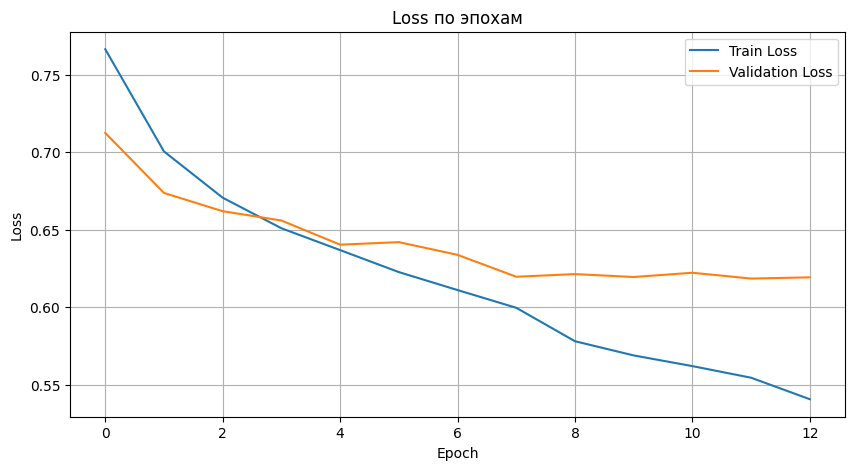

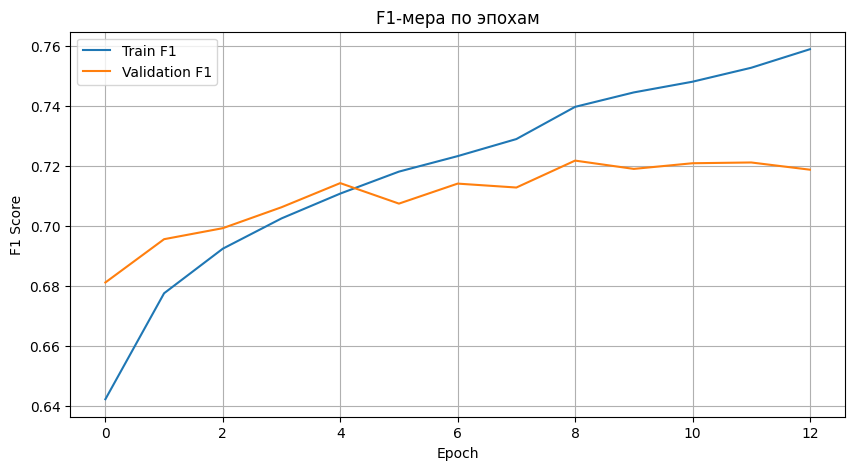

In [19]:
# loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss по эпохам")
plt.legend()
plt.grid(True)
plt.show()

# f1
plt.figure(figsize=(10, 5))
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1-мера по эпохам")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
(print(test_df))

                                                     text  label          src  \
116605                                     малы, рост 165      0    rureviews   
164033  Заказ пришёл быстро,  претензий к магазину нет...      0    rureviews   
112977  товар не получен. открыл спор по ошибке выдели...      0    rureviews   
245466        Ужасные горькие из горелой гречи. На выброс      2  perekrestok   
101678                                          жира мало      0  perekrestok   
...                                                   ...    ...          ...   
190814  товар не пришел деньги не вернулись.породавца ...      2    rureviews   
143747  Хорошие продавцы , все качественно и по-хороше...      1          geo   
7181    на рост 170 вес 60 рукава нормальные а вот в п...      0    rureviews   
13479   Работа офиса отвратительная, мало того что ран...      2          geo   
178046  Бессмысленно и беспощадно. Честно говоря, даже...      2        anime   

                           

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Test: 100%|██████████| 454/454 [01:32<00:00,  4.89it/s]


=== Test set results ===
Accuracy : 0.7074
Precision: 0.7205
Recall   : 0.7073
F1 (macro): 0.7109

Classification report:
              precision    recall  f1-score   support

           0     0.5908    0.6498    0.6189      4829
           1     0.8716    0.7258    0.7921      4844
           2     0.6989    0.7462    0.7218      4850

    accuracy                         0.7074     14523
   macro avg     0.7205    0.7073    0.7109     14523
weighted avg     0.7206    0.7074    0.7110     14523



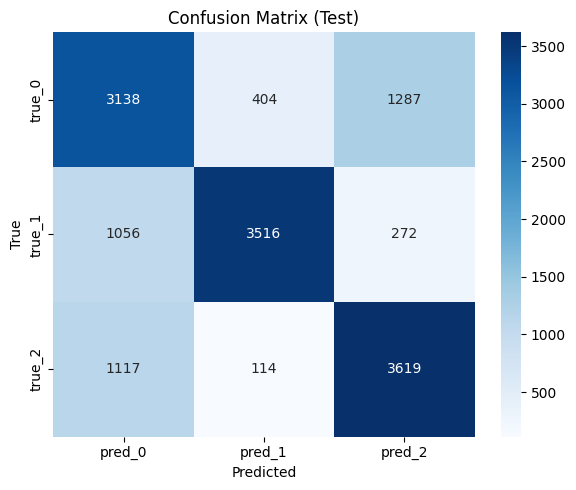

In [22]:
model = CNN_BiLSTM_Attention(BERT_MODEL, NUM_CLASSES, freeze_bert=True).to(DEVICE)
model.load_state_dict(torch.load("cnn_bilstm_attention1.pt"))
model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(input_ids, attention_mask)      # логиты [batch, num_classes]
        preds   = torch.argmax(outputs, dim=1)          # индексы предсказаний

        test_preds .extend(preds.cpu().tolist())        # собираем все предсказания
        test_labels.extend(labels.cpu().tolist())       # и все истинные метки

acc   = accuracy_score(test_labels, test_preds)
prec  = precision_score(test_labels, test_preds, average='macro')
rec   = recall_score(test_labels, test_preds,    average='macro')
f1    = f1_score(test_labels, test_preds,        average='macro')

print("=== Test set results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 (macro): {f1:.4f}\n")

print("Classification report:")
print(classification_report(test_labels, test_preds, digits=4))

# строим матрицу ошибок
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"pred_{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"true_{i}" for i in range(NUM_CLASSES)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()